In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics
import scipy.stats as stats
import pylab
%matplotlib inline

In [2]:
#import csv cancer file.
cancer_df = pd.read_csv('CosmicMutantExport.csv')

One of the most fundamental questions to answer before beginning a deeper analysis of this data set is what types of cancer are present in this data set? As you can see in the table below, there are a wide variety of cancers that were present. The occurrences of these cancers range from hundreds of thousands down to a single instance. In order to focus my investigation, I selected the three most common types of cancers in this data set. In this case, the three were large intestinal, skin, and lung cancer, in that order.

In [3]:
cancer_df.groupby(['Primary site']).size().sort_values(ascending=False)

Primary site
large_intestine                                228696
skin                                           153686
lung                                           103801
liver                                           78347
haematopoietic_and_lymphoid_tissue              56167
breast                                          49654
stomach                                         49111
endometrium                                     47781
upper_aerodigestive_tract                       40139
oesophagus                                      33234
thyroid                                         30714
prostate                                        24867
pancreas                                        21122
central_nervous_system                          20622
NS                                              19910
kidney                                          18820
urinary_tract                                   18173
ovary                                           11056
cervix         

In [4]:
#group by cancer type, then add all the cases and sort by size, returning the largest 3.
cancer_df.groupby(['Primary site']).size().sort_values(ascending=False)[:3]

Primary site
large_intestine    228696
skin               153686
lung               103801
dtype: int64

Most data sets have missing data, so data must be processed in a way that that allows for proper analyses. In this case, one of my first objectives was discovering if there were any differences in ages between the primary cancer forms. To do this, I created a function that would pass the type of cancer selected as an argument, and the function would return a new data frame with only the records that had a recorded age in that type of cancer. I then created a function that would iterate the total number of cases, the mean, the standard deviation, and the standard error to a new list from an earlier list of cancer data frames. This list was then turned into an array and subsequently converted into a data frame.

The percentage of data loss due to incomplete sets can vary with medical data. As this data comes from several sources, it is likely some of the organizations didn't record any personal demographic data at all, including age. Therefore, a loss of about 25% is not unusual for this type of medical data.

In [5]:
#Utilize an internal function (lambda) to isolate a single form of cancer.
def clean_up(type):
    new_df = cancer_df.loc[lambda df: cancer_df['Primary site'] == type]
    new_df = new_df[np.isfinite(new_df['Age'])]
    return new_df

In [6]:
#return 3 clean data frames of lung, skin, and large intestinal cancer.
lung_df = clean_up('lung')
skin_df = clean_up('skin')
lintestine_df = clean_up('large_intestine')

cancer_3 = [skin_df, lung_df, lintestine_df]

In [7]:
#calculate the percent of cases that were removed due to not having an age during the clean function.
def total_loss(c_type, datafr):
    total = cancer_df.groupby('Primary site')['Gene name'].count().loc[c_type]
    ind = datafr.groupby('Primary site')['Age'].count().loc[c_type]
    #returns only the first 4 characters of the percent, for aesthetics.
    return str((1 - (ind / total)) * 100)[:4] + '%'
    
lost_list = pd.DataFrame([total_loss('lung', lung_df), total_loss('skin', skin_df), total_loss('large_intestine', lintestine_df)])
lost_list.index= ['Lung Cancer', 'Skin Cancer', 'Large Intestine Cancer']
lost_list.columns = ['Percent Lost']
lost_list

,Percent Lost
Lung Cancer,25.8%
Skin Cancer,23.9%
Large Intestine Cancer,26.3%


In [8]:
#rather than using the describe function, I created my own function that would include count and standard error.
#the count or number of samples is relevant to the standard error.
def cancer_stats(c_list):
    new_list = []
    for x in c_list:
        count = x['Age'].count()
        mean = x['Age'].mean()
        std = np.std(x['Age'], ddof=1)
        se = std / np.sqrt(len(x['Age']))
        new_list.append([count, mean, std, se])
    return new_list

In [9]:
#a function designed to use the cancer stat function and create a dataframe from a list of cancers.
def create_df(c_list):
    stats_array = np.array(cancer_stats(c_list))
    stats_df = pd.DataFrame(stats_array)
    return stats_df

cancer3_df = create_df(cancer_3)
cancer3_df.index = ['Skin', 'Lung', 'Large Intestine']
cancer3_df.columns = ['Count', 'Mean', 'Standard Deviation', 'Standard Error']
cancer3_df

,Count,Mean,Standard Deviation,Standard Error
Skin,116928.0,63.666873,15.198847,0.044448
Lung,76962.0,64.384129,9.813494,0.035374
Large Intestine,168367.0,68.010699,11.870562,0.028930


In [10]:
#import t-test from scipy
from scipy.stats import ttest_ind

#seed the random number selection and choose 50 samples from each cancer data frame
np.random.seed(1337)
lung_sample = np.random.choice(lung_df['Age'], size=50, replace=True)
skin_sample = np.random.choice(skin_df['Age'], size=50, replace=True)
intestinal_sample = np.random.choice(lintestine_df['Age'], size=50, replace=True)
#run a test between all 3 cancer types
t_test = ttest_ind(skin_sample, lung_sample, equal_var=False)
print(t_test)

Ttest_indResult(statistic=-0.51498719670437487, pvalue=0.60795815903824479)


In [11]:
t_test2 = ttest_ind(skin_sample, intestinal_sample, equal_var=False)
print(t_test2)

Ttest_indResult(statistic=-1.1761592781102956, pvalue=0.24312085412659951)


In [12]:
t_test3 = ttest_ind(lung_sample, intestinal_sample, equal_var=False)
print(t_test3)

Ttest_indResult(statistic=-0.89434441535940479, pvalue=0.3733415360962461)


In the table above, you can see there are significant differences amongst the types of cancers. The average age of a person with cancer of the large intestine is four and a half years older than the average age of a person with skin cancer. What stands out most to me are the differences in standard deviation. Lung cancers are 33% less variable from the mean than skin cancers. This indicates that skin cancers can be more prevalent at any age, while lung cancers are more likely to form in a narrower age range. The standard errors of all of our samples were extremely low, which can be explained by the very large sample size we are utilizing. To get a better look at the impact of standard error, it will be important to use a smaller sample. We will be looking at more in depth, smaller samples later. Also, while a t-test might not be the best choice for this data set, they were run to determine if there were any significant differences between the distributions of the ages for our three forms of cancer. The p-values from the t-tests show that the distributions of ages are not significantly different at a significance level below 5%. Visualizing the data is equally important to knowing the descriptive statistics. Below, you can see each cancer type’s age distributions as a histogram.

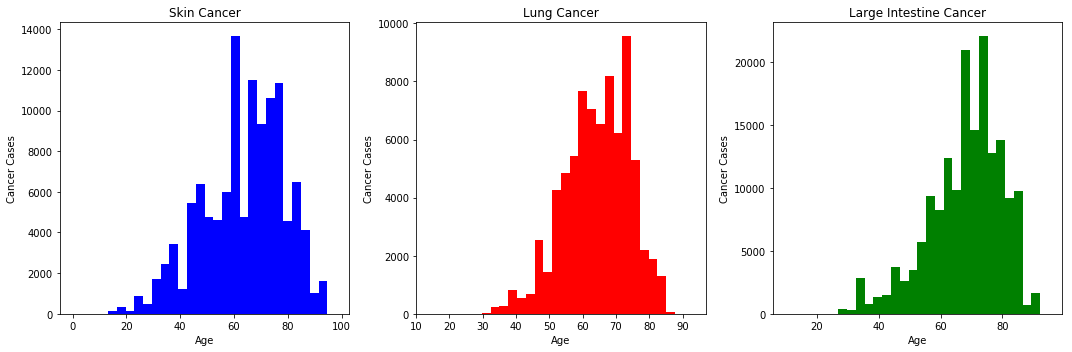

In [13]:
#creates histograms of the cancer list previously defined
def main_plt():
    plt.figure(figsize=(15, 5))
    cancers = [skin_df, lung_df, lintestine_df]
    colors = ['blue', 'red', 'green']
    n = 1
    y = 0
    #set variable titles equal to the indexes of the cancer_3 list
    titles = [x.replace(x, x + ' Cancer') for x in cancer3_df.index.values] 
    for cancer in cancers:
        plt.subplot(1, 3, n)
        plt.hist(cancer['Age'], bins = 30, color=colors[y]) 
        plt.xlabel('Age')
        plt.ylabel('Cancer Cases')
        plt.title(titles[y])
        n += 1
        y += 1 
    plt.tight_layout()
    plt.show()
    
    
main_plt()  
    

Immediately we see that none of our distributions are perfectly normal. At varying levels, all of the forms of cancer skewed to the left. In the skin and lung cancer distributions, we also see the formation of a bimodal distribution, with a spike in the population before 40 and 50 respectively. These distributions can be attributed to lifestyle choices. We know that excess UV exposure and smoking can cause abnormally high rates of cancer in younger individuals. A follow up study would be to isolate those particular age ranges and compare them to the total population to see if any differences emerge. As an additional note, while selecting bin size can be done via formula (square-root choice, etc.), a bin size of 30 was selected via trial and error.

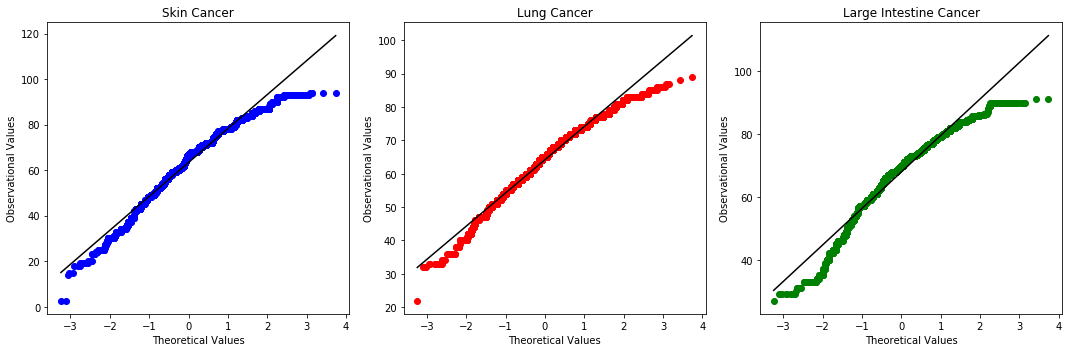

In [14]:
#a function that samples 5000 values from each unique cancer data frame and returns a qq plot
#5000 values was less than 10% of the total sample for each data set, but returned similar plot shapes
def qq_plot():
    norm = np.random.normal(0, 1, 5000)
    norm.sort()
    plt.figure(figsize=(15, 5))
    cancers = [skin_df, lung_df, lintestine_df]
    colors = ['blue', 'red', 'green']
    n = 1
    y = 0
    titles = [x.replace(x, x + ' Cancer') for x in cancer3_df.index.values]
    for cancer in cancers:
        #selecting 5000 random samples then sorting them
        a = cancer_random = np.random.choice(cancer['Age'], 5000, replace=True)
        cancer_random.sort()
        plt.subplot(1, 3, n)
        # creating the q-q plot
        plt.plot(norm, cancer_random, 'o', color=colors[y])
        #creating a regression line fit to the plot
        z = np.polyfit(norm, a, 1)
        p = np.poly1d(z)
        pylab.plot(norm,p(norm),color='black')
        plt.title(titles[y])
        plt.ylabel('Observational Values')
        plt.xlabel('Theoretical Values')
        n += 1
        y += 1
    plt.tight_layout()
    plt.show()

qq_plot()

There are several interesting observations that can be made from the q-q plots above. First, the upward bend of the plot indicates that all the cancer sets have some leftward skew to them, in varying levels. Cancers of the large intestine display the most amount of leftward skew. Also, all of the cancers seem to have a hard ceiling of around 90 years old. This is likely due to the fact that treatments for cancers late in life are often more lethal than the cancers themselves. The survival rate of cancer at age 90 or above is almost zero. Also, while large intestinal and lung cancers seem to have a hard floor around 30, skin cancers do not. This is likely due to a combination of genetic factors and extended sun exposure at a very young age.

In [15]:
#creates two functions, one for cancers under the age of 40, more likely to be associated with lifestyle choices,
#and another for cancers presenting at 70 or higher, more likely due to aging.
def lifestyle(cancers):
    new_df = cancers.loc[lambda df: cancers['Age'] < 41]
    return new_df

def age(cancers):
    new_df = cancers.loc[lambda df: cancers['Age'] > 69]
    return new_df

#returning an array of people with skin cancer 40 and under, and another for people 70 and over.
under_40 = lifestyle(skin_df)
over_70 = age(skin_df)

Continuing with the follow up mentioned previously, functions were created to isolate two age ranges. The first was for people who had cancer, in this case skin cancer, under the age of 40. Prevalence of cancer at this age is extremely likely to be caused by lifestyle choices, in this case normally an excess of UV exposure. The second function isolated skin cancers formed after the age of 70, at which time the cancer's origin was likely due to age and not so much lifestyle (although excessive UV exposure at a younger age increases your likelihood of getting skin cancer when you are older.)

In [16]:
#groups the two previous arrays by the predicted site of the carcenoginic mutation and creates a dataframe.
def mutation(data_set):
    new_df = data_set.groupby(['Mutation AA']).size().sort_values(ascending=False)[:10]
    return new_df

skin_70 = pd.DataFrame(mutation(over_70),
                       columns=['> 70'])
skin_40 = pd.DataFrame(mutation(under_40),
                       columns=['< 40'])

It is vital to see if there are differences in mutation locations for people who have lifestyle-induced cancers vs age-induced cancers. Primary analysis of predicted mutation locus will return =?, meaning the algorithm cannot determine the site of the mutation as the most populated result. As unknown sites aren't useful for us in this analysis, I have removed that grouping from the results so we can better see the 10 most prevalent mutation sites. The primary mutation site in both people over 70 and under 40 is at p.V600E, although the distributions vary enormously. In individuals with skin cancer under 40, the p.V600E locus appears approximately 400% more than the second highest site, whereas in individuals over 70, it is just 10% higher. Also, outside of sharing the highest mutation locus, none of the remaining nine loci are shared between the two groups. The causational mutation sites between the two groups are astoundingly unique.

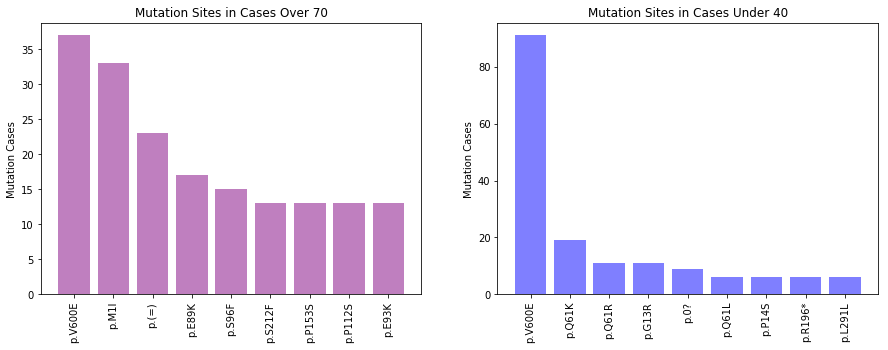

In [17]:
#creates two bargraphs comparing the sites of mutations for people under 40 and over 70.
plt.figure(figsize=(15, 5))

objects = skin_70.index
objects2 = skin_40.index
y_pos = np.arange(len(objects) - 1)

plt.subplot(1, 2, 1)
plt.bar(y_pos, skin_70['> 70'][1:], align='center', alpha=0.5, color='purple')
plt.xticks(y_pos, objects[1:], rotation='vertical')
plt.ylabel('Mutation Cases')
plt.title('Mutation Sites in Cases Over 70')

plt.subplot(1, 2, 2)
plt.bar(y_pos, skin_40['< 40'][1:], align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects2[1:], rotation='vertical')
plt.ylabel('Mutation Cases')
plt.title('Mutation Sites in Cases Under 40')

plt.show()


In [18]:
#return the percentage of the whole a particular gene makes up, ignoring the first gene
def percent_total(data_frame, gene):
    return data_frame.loc[gene] / data_frame[1:].sum()

In [19]:
percent_total(skin_70, 'p.V600E')

> 70    0.20904
dtype: float64

In [20]:
percent_total(skin_40, 'p.V600E')

< 40    0.551515
dtype: float64

The ability to differentiate between cancers caused by lifestyle and age may allow us to better predict and potentially protect individuals from developing tumors before they can become cancerous. A deeper and more in-depth analysis may allow us to inform individuals when they are at risk for skin cancers, before tumors even develop. Further research should be done surrounding these specific gene locations. A comparison of genomes between cancer patients and healthy individuals could provide clues as to genomic "weaknesses" that could increase the likelihood of developing skin cancer. Also, yearly genomic analysis, including during checkups, could warn doctors that a patient may have developed a dangerous mutation. Eventually, using genomic editing, we may be able to reverse these mutations as they occur, protecting individuals from dangerous mutations. Combining data science with modern medicine, we stand on the forefront of saving lives.